In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
cos = nn.CosineSimilarity(dim=0, eps=1e-9)
from torchvision import transforms
from models import ConvNet, resnet8, MLP
from utils import *
from torch.utils.data import DataLoader
device = "cuda"

In [2]:
# Define transformation (convert images to tensors and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image with mean and std
])

# Load the training dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Load the test dataset
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batch processing
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
client_loaders, test_loader, client_data_subsets = data.get_loaders(train_data, test_data, n_clients=100,
                                                                        alpha=1, batch_size=32, n_data=None, num_workers=4, seed=4)

Data split:
 - Client 0: [226  18  19  79  27 116  25   3  35  47]               -> sum=595
 - Client 1: [ 86  54   6  41   2  98 160 128   4  20]               -> sum=599
 - Client 2: [150  21  89  25   3  55  60 178   2  19]               -> sum=602
 - Client 3: [ 59 103  22 131 163   9  28  29   2  53]               -> sum=599
 - Client 4: [ 61 185  28  97  35  54  23   9   2 106]               -> sum=600
 - Client 5: [ 17  64  24  20  10 229 121  28  24  63]               -> sum=600
 - Client 6: [232   5   9  30   7 123   7  20  93  75]               -> sum=601
 - Client 7: [  0  71  38  46  45  74   1  81 155  87]               -> sum=598
 - Client 8: [ 22  79  22   9  83 138  50  82  37  79]               -> sum=601
 - Client 9: [29 83 47 76 98 26 25 55 72 89]                         -> sum=600
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
 - Client 91: [ 18  44  49  84  21  49 141  47  83  62]               -> sum=598
 - Client 92: 

In [3]:
# setup the environment
client_loader = client_loaders[0]
model1 = ConvNet(im_size = (28,28), dataset = 'fmnist').to(device)
model2 = ConvNet(im_size = (28,28), dataset = 'fmnist').to(device)
model3 = ConvNet(im_size = (28,28), dataset = 'fmnist').to(device)

# model1 = resnet8(dataset = 'fmnist').to(device)
# model2 = resnet8(dataset = 'fmnist').to(device)
# model3 = resnet8(dataset = 'fmnist').to(device)
model0 = {k: v.clone().detach() for k, v in model1.state_dict().items()}
model2.load_state_dict(model1.state_dict())

optimizer1 = optim.SGD(model1.parameters(), lr=0.001)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001)

# train with benign and the malicious model

train_op(model1, client_loader, optimizer1, epochs=1, print_train_loss=True)
train_op_tr_flip(model2, client_loader, optimizer2, epochs=1, class_num=10, print_train_loss=True)

num feat 2048
num feat 2048
num feat 2048
[2.39, 2.15, 1.96, 1.86, 1.76, 1.7, 1.65, 1.61, 1.56, 1.52]
[2.31, 1.9, 1.73, 1.95, 1.89, 1.39, 1.72, 1.62, 1.43, 1.67]


{'loss': 1.7412922977399425}

In [4]:
# m = resnet8( dataset = 'fmnist').to(device)
# sum(p.numel() for p in m.parameters())

In [5]:
def model_eval(model, test_loader):
    acc = eval_op_ensemble([model], test_loader)
    asr = eval_op_ensemble_tr_lf_attack([model], test_loader)
    return list(acc.values())[0], list(asr.values())[0]

In [6]:
model_eval(model1, test_loader)

(0.1967, 0.0)

In [7]:
model_eval(model2, test_loader)

(0.1981, 0.997)

In [8]:
flat_model0 = flat_dict(model0)
flat_model1 = flat_dict(model1.state_dict())
flat_model2 = flat_dict(model2.state_dict())

In [9]:
# find the reference for TopK
delta = torch.abs(flat_model1 - flat_model2)
delta = torch.abs(torch.mul((flat_model1 - flat_model2), flat_model2))

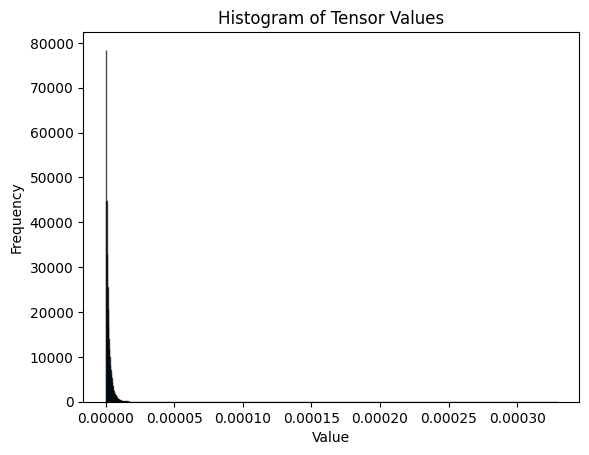

In [10]:
plt.hist(delta.cpu().detach().numpy(), bins=1000, edgecolor='black', alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Tensor Values")
plt.show()

In [11]:
# cos between model1 and model2
org_cos = cos((flat_model1 - flat_model0), (flat_model2 - flat_model0))

In [12]:
org_cos

tensor(0.3083, device='cuda:0')

In [13]:
# budget_list = np.arange(0, 1-org_cos.item(), 0.01)
budget_list = np.linspace(start=0, stop=1-org_cos.item(), num=50)

In [14]:
budget_list

array([0.        , 0.01411597, 0.02823195, 0.04234792, 0.05646389,
       0.07057987, 0.08469584, 0.09881181, 0.11292779, 0.12704376,
       0.14115973, 0.15527571, 0.16939168, 0.18350765, 0.19762363,
       0.2117396 , 0.22585557, 0.23997155, 0.25408752, 0.26820349,
       0.28231947, 0.29643544, 0.31055141, 0.32466739, 0.33878336,
       0.35289933, 0.36701531, 0.38113128, 0.39524726, 0.40936323,
       0.4234792 , 0.43759518, 0.45171115, 0.46582712, 0.4799431 ,
       0.49405907, 0.50817504, 0.52229102, 0.53640699, 0.55052296,
       0.56463894, 0.57875491, 0.59287088, 0.60698686, 0.62110283,
       0.6352188 , 0.64933478, 0.66345075, 0.67756672, 0.6916827 ])

In [15]:
def replace_topk_budget_cos(a: torch.Tensor, b: torch.Tensor, delta: torch.Tensor, server:torch.Tensor, budget: float):
    """
    Replaces elements in `a` with corresponding elements from `b` based on the top-k values in `delta`,
    ensuring that the cosine similarity between the modified `a` (denoted as `c`) and the original `a`
    satisfies (1 - cos(a, c)) <= budget.

    Args:
        a (torch.Tensor): Original tensor.
        b (torch.Tensor): Replacement tensor.
        delta (torch.Tensor): Difference tensor used for ranking replacements.
        budget (float): Maximum allowable cosine distance between `a` and the modified tensor `c`.

    Returns:
        torch.Tensor: Modified tensor `c` with selected replacements.
    """
    flat_delta = delta.view(-1)
    flat_a = a.view(-1)
    flat_b = b.view(-1)
    flat_s = server.view(-1)
    
    # Sort indices by delta in descending order (top-k replacement candidates)
    sorted_indices = torch.argsort(flat_delta, descending=True)
    
    c = flat_a.clone()
    best_c = c.clone()
    best_cos_dist = 1 - torch.nn.functional.cosine_similarity((flat_a-flat_s).view(1, -1), 
                                                              (best_c-flat_s).view(1, -1)).item()
    # print(f"initial cos {best_cos_dist}")
    left, right = 0, len(sorted_indices)
    
    while left < right:
        
        mid = (left + right) // 2 
        c[:] = flat_a  # Reset c to original a before each iteration
        c[sorted_indices[:mid]] = flat_b[sorted_indices[:mid]]
        cos_sim = torch.nn.functional.cosine_similarity((flat_a-flat_s).view(1, -1), 
                                                        (c-flat_s).view(1, -1)).item()
        cos_dist = 1 - cos_sim
        print(f"left: {left}, right: {right}, mid: {mid}")
        if cos_dist <= budget:
            best_c = c.clone()
            best_cos_dist = cos_dist
            left = mid + 1
        else:
            right = mid 
    
    return best_c.view(a.shape), mid/len(sorted_indices)*100, best_cos_dist

In [16]:
def restore_dict_w(flat_grad, model_dict):
    restored_grad = {}
    start = 0
    for name, param in model_dict.items():
        num_elements = param.numel()
        restored_grad[name] = flat_grad[start:start + num_elements].view(param.shape)                          
        start += num_elements
    return restored_grad

In [17]:
results = []
for budget in budget_list:
    # craft the new model grad
    model3_w, k, cos_ = replace_topk_budget_cos(flat_model1, flat_model2, delta, flat_model0, budget)
    
    restored_crafted = restore_dict_w(model3_w,  model3.state_dict())
    # restore model weights to model
    model3.load_state_dict(restored_crafted)
    
    # evaluate the model3's performance on main task and attack
    acc, asr = model_eval(model3, test_loader)
    results.append([budget, acc, asr, k, cos_])
    print(f"budget:{budget}, acc:{acc}, asr:{asr}, k:{k}, cos:{cos_}")

left: 0, right: 317706, mid: 158853
left: 0, right: 158853, mid: 79426
left: 0, right: 79426, mid: 39713
left: 0, right: 39713, mid: 19856
left: 0, right: 19856, mid: 9928
left: 0, right: 9928, mid: 4964
left: 0, right: 4964, mid: 2482
left: 0, right: 2482, mid: 1241
left: 0, right: 1241, mid: 620
left: 0, right: 620, mid: 310
left: 0, right: 310, mid: 155
left: 0, right: 155, mid: 77
left: 0, right: 77, mid: 38
left: 0, right: 38, mid: 19
left: 0, right: 19, mid: 9
left: 0, right: 9, mid: 4
left: 0, right: 4, mid: 2
left: 0, right: 2, mid: 1
left: 0, right: 1, mid: 0


budget:0.0, acc:0.1967, asr:0.0, k:0.0, cos:-1.1920928955078125e-07
left: 0, right: 317706, mid: 158853
left: 0, right: 158853, mid: 79426
left: 0, right: 79426, mid: 39713
left: 0, right: 39713, mid: 19856
left: 0, right: 19856, mid: 9928
left: 0, right: 9928, mid: 4964
left: 0, right: 4964, mid: 2482
left: 0, right: 2482, mid: 1241
left: 0, right: 1241, mid: 620
left: 0, right: 620, mid: 310
left: 0, right: 310, mid: 155
left: 156, right: 310, mid: 233
left: 234, right: 310, mid: 272
left: 234, right: 272, mid: 253
left: 254, right: 272, mid: 263
left: 254, right: 263, mid: 258
left: 254, right: 258, mid: 256
left: 254, right: 256, mid: 255
left: 254, right: 255, mid: 254
budget:0.01411597339474425, acc:0.1968, asr:0.0, k:0.07994812814362964, cos:0.013859391212463379
left: 0, right: 317706, mid: 158853
left: 0, right: 158853, mid: 79426
left: 0, right: 79426, mid: 39713
left: 0, right: 39713, mid: 19856
left: 0, right: 19856, mid: 9928
left: 0, right: 9928, mid: 4964
left: 0, right: 

In [18]:
def find_differing_indices(a, b):
    """
    Finds the indices where two tensors differ.
    
    Parameters:
    a (torch.Tensor): First tensor.
    b (torch.Tensor): Second tensor.
    
    Returns:
    torch.Tensor: Indices where tensors differ.
    """
    if a.shape != b.shape:
        raise ValueError("Tensors must have the same shape")
    
    differing_indices = (a != b).nonzero(as_tuple=True)
    return differing_indices

In [19]:
flat_dict(model1.state_dict()).shape

torch.Size([317706])

In [20]:
flat_dict(model3.state_dict()).shape

torch.Size([317706])

In [21]:
find_differing_indices(flat_dict(model2.state_dict()), flat_dict(model3.state_dict()))[0]

tensor([], device='cuda:0', dtype=torch.int64)

In [22]:
flat_dict(model2.state_dict())[704]

tensor(0.0501, device='cuda:0')

In [23]:
flat_dict(model3.state_dict())[704]

tensor(0.0501, device='cuda:0')

In [24]:
results = np.array(results)

In [25]:
def plot_line(x, y, title='Line Plot', xlabel='X-axis', ylabel='Y-axis'):
    """
    Plots a line graph given x and y values.
    
    Parameters:
    x (list or array): X-axis values.
    y (list or array): Y-axis values.
    title (str): Title of the plot.
    xlabel (str): Label for the X-axis.
    ylabel (str): Label for the Y-axis.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker='o', linestyle='-', color='b', label='Line')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

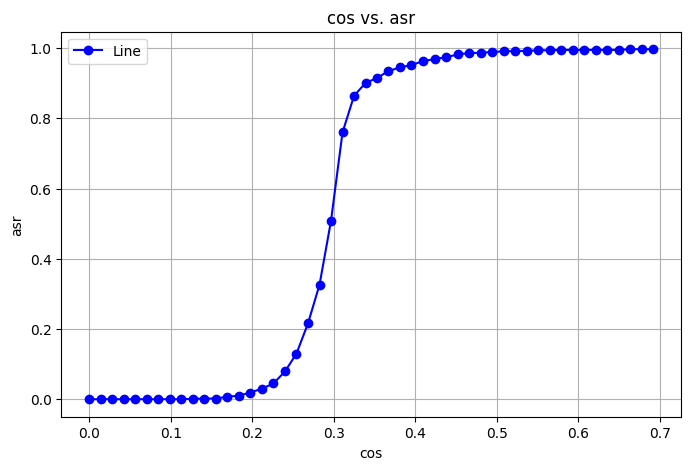

In [26]:
plot_line(results[:,4], results[:,2], title='cos vs. asr', xlabel='cos', ylabel='asr')

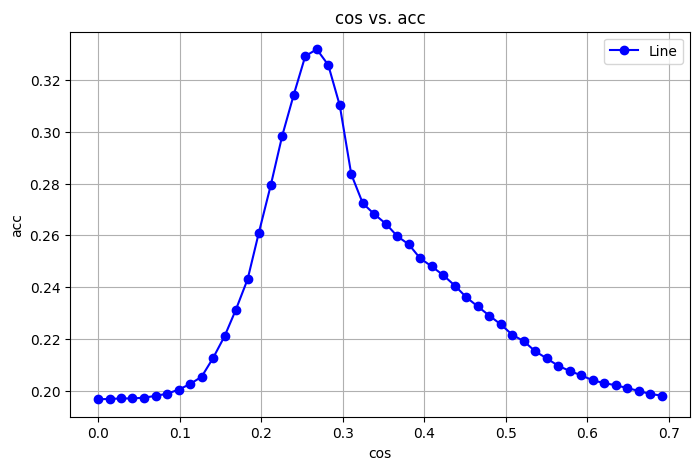

In [27]:
plot_line(results[:,4], results[:,1], title='cos vs. acc', xlabel='cos', ylabel='acc')

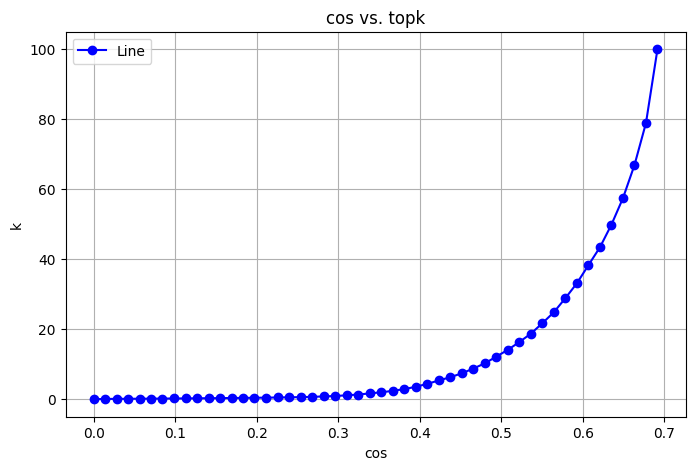

In [28]:
plot_line(results[:,4], results[:,3], title='cos vs. topk', xlabel='cos', ylabel='k')